In [165]:
# importing of libraires that will be use in the script
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
%matplotlib inline
from pandas import DataFrame
import pandas as pd
from IPython.display import display, HTML
from skimage.exposure import rescale_intensity
import plotly.graph_objects as go
import pandas as pd
import json
import os

from image_processing_utils import *

pd.options.display.html.border = 0
pd.options.display.float_format = '{:,.2f}'.format

In [5]:
# !wget -O cathedral.zip http://grail.cs.washington.edu/projects/photomontage/data/cathedral.zip && unzip -o cathedral.zip

--2022-11-06 08:59:49--  http://grail.cs.washington.edu/projects/photomontage/data/cathedral.zip
Resolving grail.cs.washington.edu (grail.cs.washington.edu)... 128.208.5.93, 2607:4000:200:14::5d
Connecting to grail.cs.washington.edu (grail.cs.washington.edu)|128.208.5.93|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1342082 (1,3M) [application/zip]
Saving to: ‘cathedral.zip’

cathedral.zip       100%[===================>]   1,28M   259KB/s    in 6,3s    

2022-11-06 08:59:56 (209 KB/s) - ‘cathedral.zip’ saved [1342082/1342082]

Archive:  cathedral.zip
  inflating: cathedral/d001.jpg      
  inflating: cathedral/d002.jpg      
  inflating: cathedral/d003.jpg      
  inflating: cathedral/d004.jpg      
  inflating: cathedral/d005.jpg      
  inflating: cathedral/result.png    


In [6]:
get_ipython()

In [166]:
def jupyter_imshow(image):
  return plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))


if 'google.colab' in str(get_ipython()):
  from google.colab.patches import cv2_imshow
  imshow = cv2_imshow
else:
  imshow = jupyter_imshow

In [167]:
files = 'cathedral/d001.jpg cathedral/d002.jpg cathedral/d003.jpg cathedral/d004.jpg cathedral/d005.jpg cathedral/result.png'.split(' ')
files

['cathedral/d001.jpg',
 'cathedral/d002.jpg',
 'cathedral/d003.jpg',
 'cathedral/d004.jpg',
 'cathedral/d005.jpg',
 'cathedral/result.png']

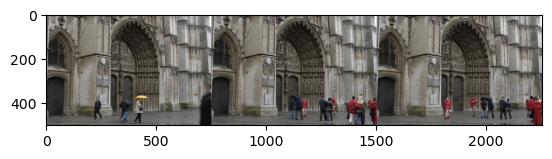

In [169]:
images = [cv2.imread(x, 1) for x in files]
images, target = images[:-1], images[-1]

imshow(np.concatenate(images[:3],1) )
# imshow(np.concatenate([np.concatenate(images[3:5],1), np.zeros(shape=target.shape)],1)[:,:500])
# imshow(target)

In [170]:
np.concatenate([np.concatenate(images[3:5],1), np.zeros(shape=target.shape)],1).shape

(500, 2256, 3)

Median approach


In [12]:
for im in images:
    print(im.shape)


(500, 752, 3)
(500, 752, 3)
(500, 752, 3)
(500, 752, 3)
(500, 752, 3)


In [250]:
median_image = get_median_image(images)

In [138]:
median_image[0,0]

array([140, 144, 154], dtype=uint8)

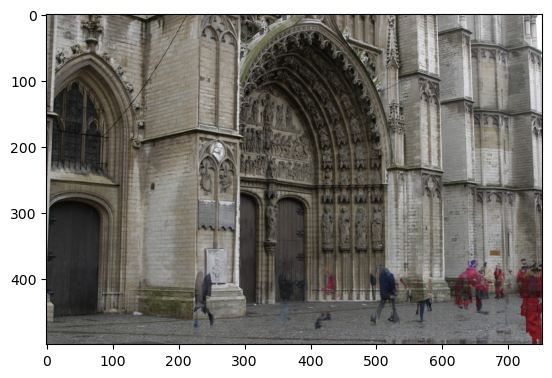

In [173]:
imshow(median_image)

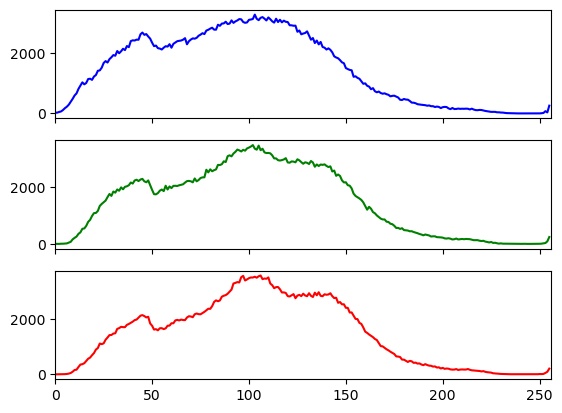

In [174]:

img = median_image
color = ('b','g','r')
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    ax[i].plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

the following is to check ... 

Finding pixels that have the same value on all images

In [178]:
no_noise_map = get_no_noise_map(images)
no_noise_map

[[ 10  86  35 144 146]
 [ 10  78  28 139 144]
 [ 10  71 113 140 144]]
[ 86  78 113]
[[False  True False False False]
 [False  True False False False]
 [False False  True False False]]


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

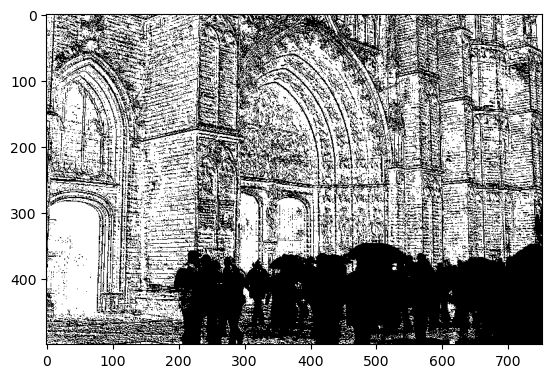

In [14]:
imshow(no_noise_map*255)

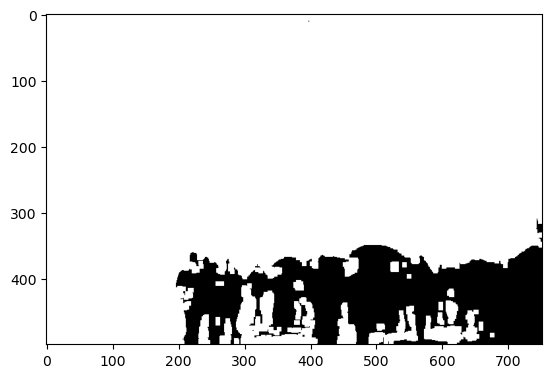

In [242]:
struct = np.ones((3,3), np.uint8)

eroded = cv2.dilate(no_noise_map, struct, iterations=3)

imshow(eroded*255)
# imshow(median_image)

In [245]:
img_closed = cv2.erode(eroded, struct, iterations=6)

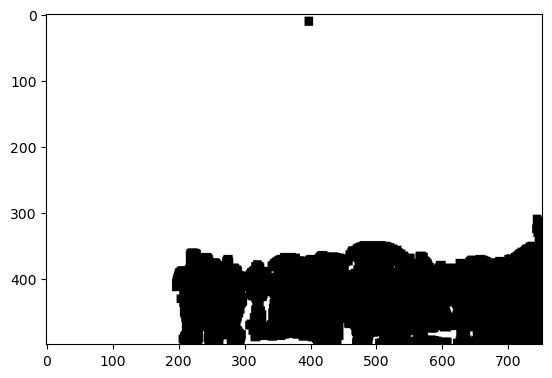

In [246]:
imshow(img_closed*255)

Automedian


In [238]:
np.ones([3,3], np.uint8)

automedian_map = Automedian(~no_noise_map.astype(bool), struct)

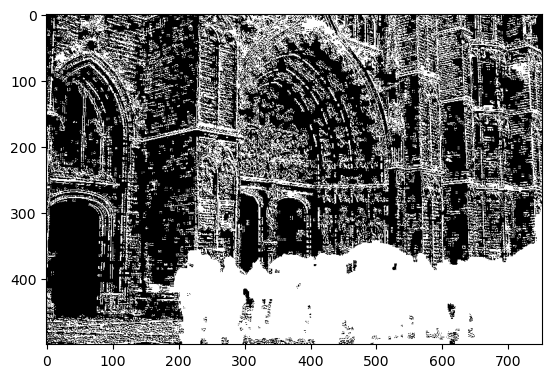

In [239]:
imshow(automedian_map*255)

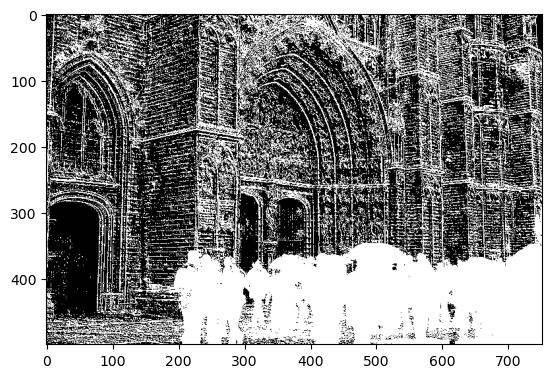

In [241]:
imshow((~no_noise_map.astype(bool)).astype('uint8')*255)

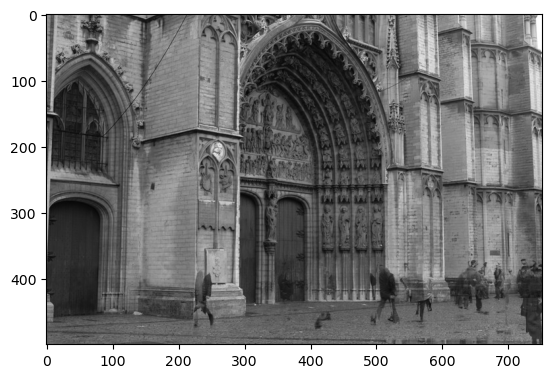

In [180]:
median_image_greyscale = cv2.cvtColor(median_image, cv2.COLOR_BGR2GRAY)
imshow(median_image_greyscale)

[[254 253 255 255 251]
 [254 253 255 255 255]
 [254 253 255 255 254]]


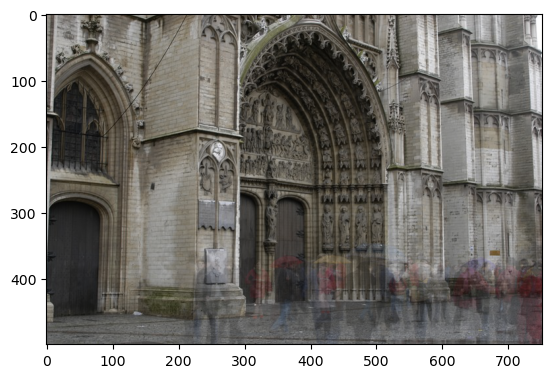

In [182]:
images_mean = get_images_averaged(images)

imshow(images_mean)

In [184]:
np.tile(np.logical_not(eroded)[...,None],3)[0,0]



array([False, False, False])

In [185]:
eroded_broadcasted = np.tile((eroded).astype('uint8')[...,None],3)*255

eroded_broadcasted[-1,-1]

array([0, 0, 0], dtype=uint8)

[1 4]
[0.24253563 0.9701425 ]
(500, 752, 3)


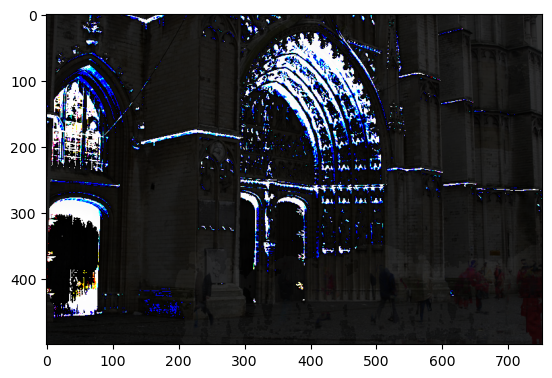

In [186]:
median_and_map = add_images(median_image, eroded_broadcasted, np.array([1,4]))
imshow(median_and_map)

In [198]:
eroded.astype('bool')

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

### Maximum Likelihood approach



In [ ]:
imshow(images[0][100:121, 100:121])

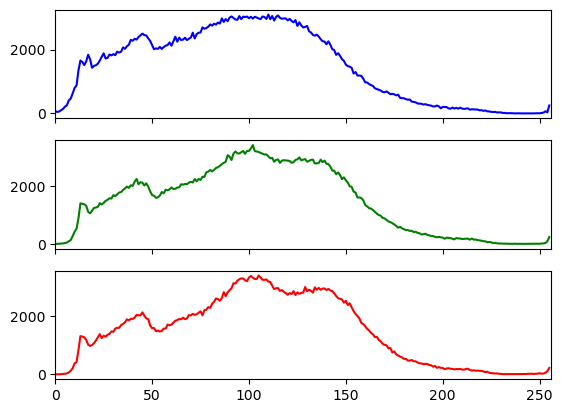

In [24]:
img = median_image
color = ('b','g','r')
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)
for i,col in enumerate(color):
    histr = cv2.calcHist(images,[i],None,[256],[0,256])
    ax[i].plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

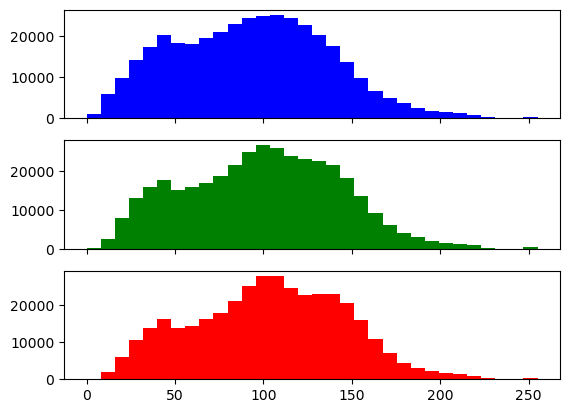

In [188]:
histogram = get_histogram([median_image], bins=32)

In [189]:
histogram, bins = np.histogram(median_image[:,:,1].flatten(), bins=8)

In [190]:
histogram

array([23606, 64674, 82634, 99846, 76359, 22394,  5780,   707])

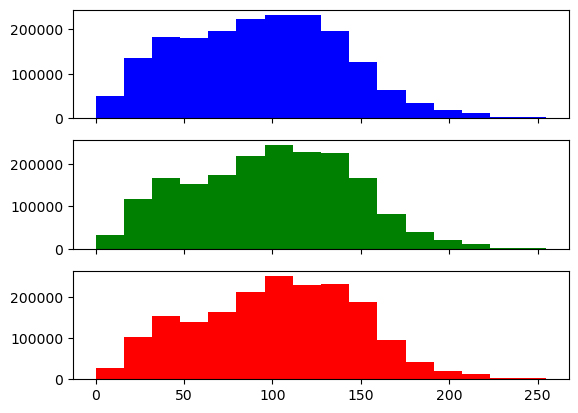

In [247]:
im_out = get_maximum_likely_image(images, bins=16, power=4, deterministic=False)

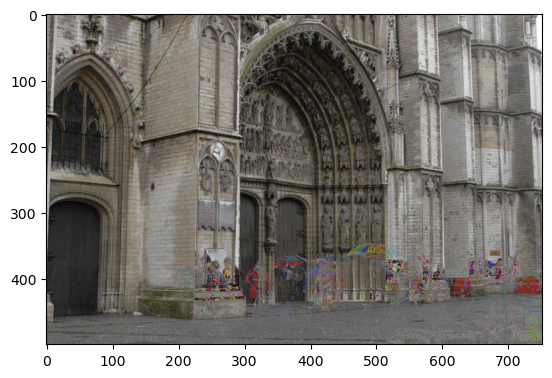

In [151]:
imshow(im_out)

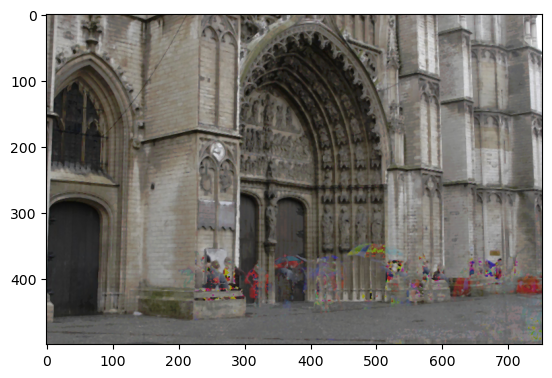

In [141]:
# median filter
median_denoised_image = cv2.medianBlur(im_out, 3)
imshow(median_denoised_image)

calculate the histogram including only pixels that are the same on all the images

(309699, 3)


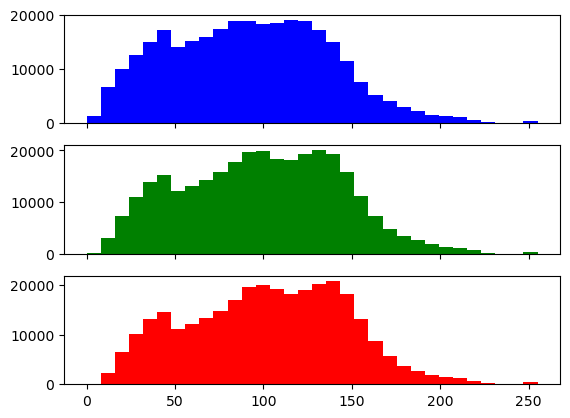

array([[ 1420,  6671,  9943, 12632, 14977, 17139, 14184, 15272, 15897,
        17491, 18865, 18863, 18346, 18523, 19101, 18864, 17301, 15024,
        11487,  7680,  5215,  4058,  3040,  2198,  1638,  1322,  1117,
          694,   274,    41,    14,   408],
       [  188,  3016,  7394, 11030, 13980, 15285, 12191, 13198, 14265,
        15763, 17688, 19668, 19820, 18267, 18246, 19402, 20035, 19394,
        15855, 11165,  7237,  4889,  3434,  2587,  1811,  1362,  1211,
          705,   179,    15,    19,   400],
       [  120,  2322,  6421, 10082, 13154, 14499, 11030, 12174, 13425,
        14661, 17016, 19474, 20060, 19259, 18083, 18930, 20161, 20821,
        18135, 13139,  8659,  5668,  3672,  2766,  1910,  1443,  1258,
          737,   181,    19,    25,   395]])

In [154]:
get_hist_of_certain_pixels(images[1], eroded, bins=32)

get the pixels for 

(322606, 3)


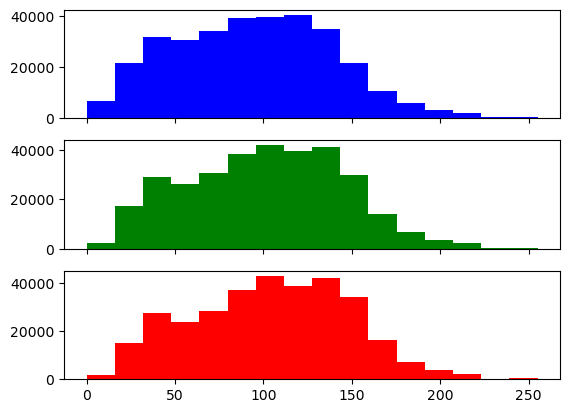

In [248]:
im_out2 = get_maximum_likely_image(images, bins=16, power=1, deterministic=True, masked_histogram=True, mask=eroded)

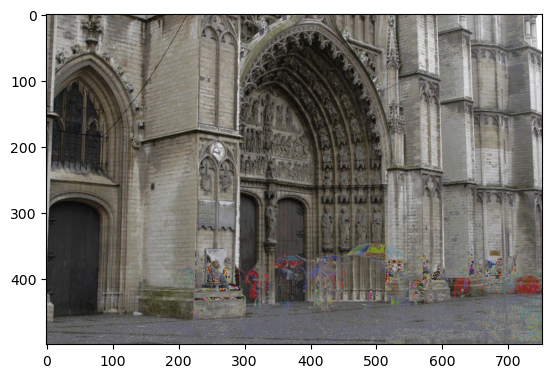

In [249]:
imshow(im_out2)

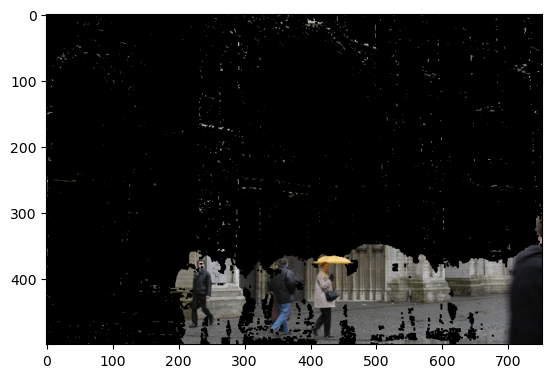

In [206]:
image_masked = get_image_masked(images[0], eroded, reversed=True)
imshow(image_masked)

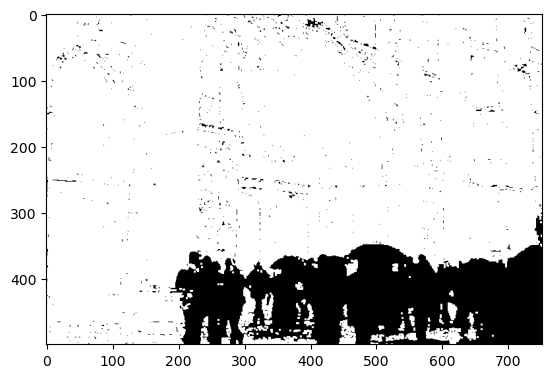

In [200]:
imshow(eroded*255)

(322606, 3)


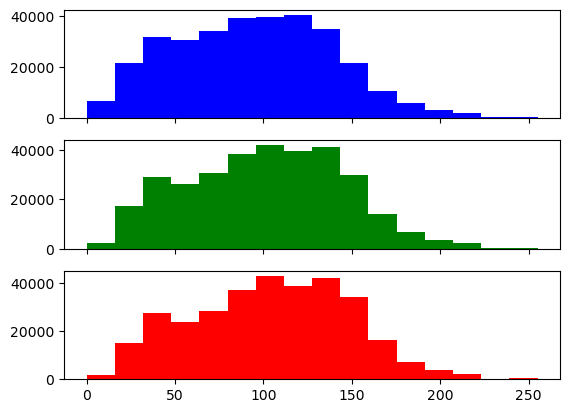

In [256]:
images_and_median = images + [median_image]*3

img_best = get_maximum_likely_image(images, bins=16, power=4, masked_histogram=True, mask=eroded)

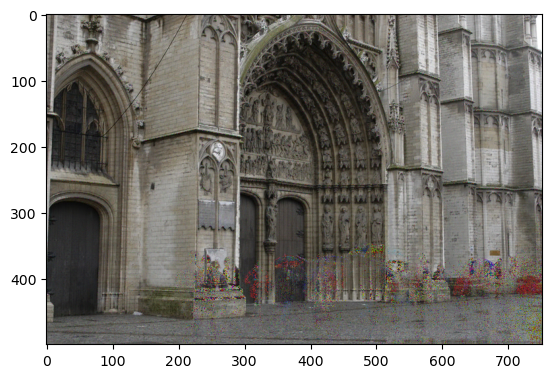

In [252]:
imshow(img_best)

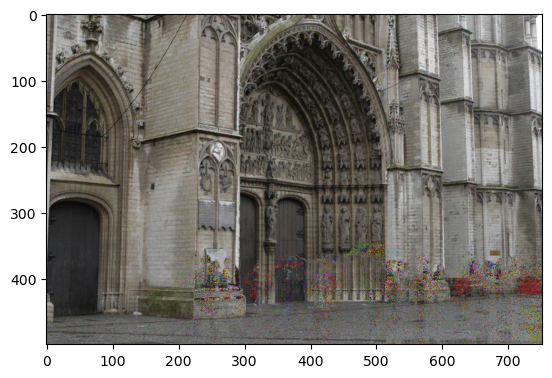

In [255]:
imshow(img_best)

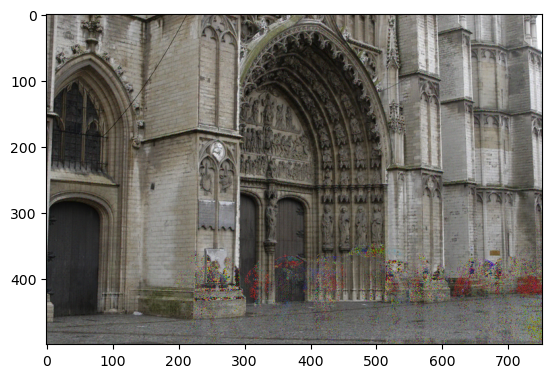

In [257]:
imshow(img_best)

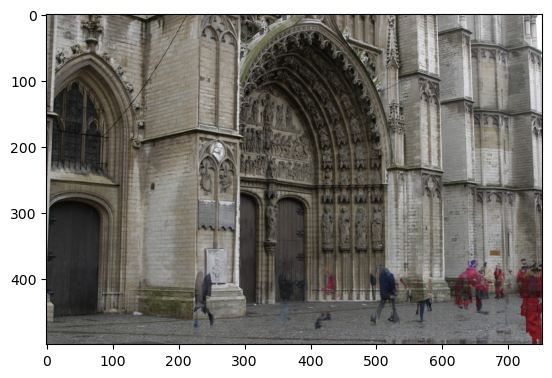

In [258]:
imshow(median_image)

In [ ]:
# histograms over neighbourhoods


# median over the neighbourhood



# median using overriden image (over the neighbouhood)